In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import cx_Oracle as db
import numpy
import pandas
from datetime import datetime as dt

import src.read_wfdisc

In [2]:
with open('/home/hofman/.dbp.txt', 'r') as f:
    dbpwd = f.read().strip()
    connection_qandef = db.connect('hofman[retraining]/%s@%s' % (dbpwd, 'dba1091.qandef'))
    connection_udb = db.connect('hofman/%s@%s' % (dbpwd, 'udb.ctbto.org')) #, encoding = "UTF-8", nencoding = "UTF-8")
    connection_extadb = db.connect('hofman/%s@%s' % (dbpwd, 'extadb.ctbto.org'))
    connection_extadb2 = db.connect('hofman/%s@%s' % (dbpwd, 'extadb.ctbto.org'))

In [3]:
#connection_qandef.close()

In [4]:
cursor_qandef = connection_qandef.cursor()
cursor_udb = connection_udb.cursor()
cursor_extadb = connection_extadb.cursor()
cursor_extadb2 = connection_extadb2.cursor()

## Extract associated waveforms from the LEB

In [24]:
key_iphase_noise = ('N',)
key_iphase_regS = ('Sn', 'Lg', 'Rg', 'Sx', 'LR')
key_iphase_regP = ('Pn', 'Pg', 'Px')
key_iphase_tele = ('P', 'PKP', 'PKPbc', 'PcP', 'PKPab', 'pP', 'PP', 'PKKPbc', 'ScP', 'SKPbc', 'PKhKP', 'PKiKP', 'PKP2', 'Pdiff', 'pPdiff', 'SKP', 'pPKP', 'PKKPab', 'pPKPbc', 'PKKP', 'SKKPbc', 'PKP2bc', 'P3KPbc', 'sP', 'SKPab', 'P4KPbc', 'PKP2ab', 'pPKPab', 'P3KP', 'SKKP', 'SKiKP', 'SKKPab', 'SKKS', 'P4KP', 'SP', 'S', 'ScS', 'SS', 'Sdiff', 'pPcP', 'sPKP', 'tx')

key_phase_regS  = ('Sn', 'Lg', 'Rg', 'LR')
key_phase_regP  = ('Pn', 'Pg')
key_phase_tele  = ('P', 'PKP', 'PKPbc', 'PcP', 'PKPab', 'pP', 'PP', 'PKKPbc', 'ScP', 'SKPbc', 'PKhKP', 'PKiKP', 'PKP2', 'Pdiff', 'pPdiff', 'SKP', 'pPKP', 'PKKPab', 'pPKPbc', 'PKKP', 'SKKPbc', 'PKP2bc', 'P3KPbc', 'sP', 'SKPab', 'P4KPbc', 'PKP2ab', 'pPKPab', 'P3KP', 'SKKP', 'SKiKP', 'SKKPab', 'SKKS', 'P4KP', 'SP', 'S', 'ScS', 'SS', 'Sdiff', 'pPcP', 'sPKP')

DIPHASECL = {key_iphase_noise: 'N',
             key_iphase_regS: 'S',
             key_iphase_regP: 'P',
             key_iphase_tele: 'T'}

DIPHASECLNUM = {'N': 0,
                'S': 1,
                'P': 2,
                'T': 3}

DPHASECL = {key_phase_regS: 'S',
            key_phase_regP: 'P',
            key_phase_tele: 'T'}

DPHASECLNUM = {'S': 1,
               'P': 2,
               'T': 3}


def get_phase_cl(phase, DPHASE):
    for key in DPHASE.keys():
        if phase in key:
            return DPHASE[key]


In [25]:
def ts(*date):
    """
    wotks in py3
    :param datetime:
    :return: timestamp from datetime
    """
    #print(dt(*date), dt(*date).timestamp())
    return dt(*date).timestamp()


def get_channels_of_sta(sta):
    query = """select distinct(chan) from static.sitechan where sta=:1 and offdate=-1"""
    res = cursor_extadb2.execute(query, (sta,))
    return tuple(sorted((x[0] for x in res)))


def get_samprate_3C(sta, time):
    channels = get_channels_of_sta(sta)
    query = """select distinct(samprate) from idcx.wfdisc where sta='%s' and chan in %s and time<= %10.9f and endtime >= %10.9f""" % (sta, str(channels), time, time)
    res = cursor_extadb2.execute(query)
    samprates = list((x[0] for x in res))
    if min(samprates) == max(samprates):
        return samprates[0]
    else:
        print('Different samprates in channel!!!', samprates)
        return None
    
    
def get_calibs(sta, time):
    channels = get_channels_of_sta(sta)
    query = """select chan, calib from idcx.wfdisc where sta='%s' and chan in %s and time<= %10.9f and endtime >= %10.9f""" % (sta, str(channels), time, time)
    res = cursor_extadb2.execute(query).fetchall()
    
    calibs_d = {x[0]:x[1] for x in res}
    calibs = (calibs_d[x] if x in calibs_d.keys() else None for x in channels)
    return tuple(calibs)

# tests
channels = get_channels_of_sta('JCJ')
assert channels == ('BHE', 'BHN', 'BHZ')
assert get_samprate_3C('JCJ', 1563194400) == 40.0
assert get_calibs('JCJ', 1563494400) == (0.038118, 0.038131, 0.038104)

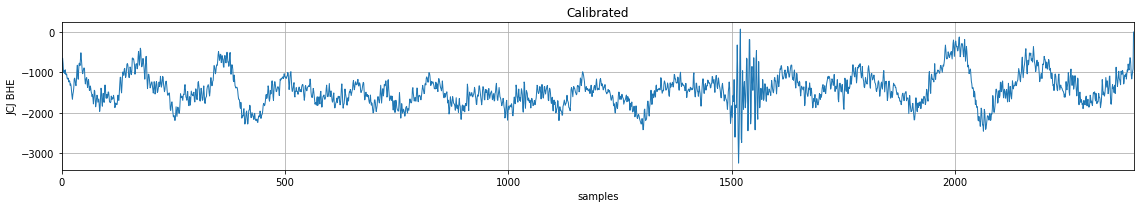

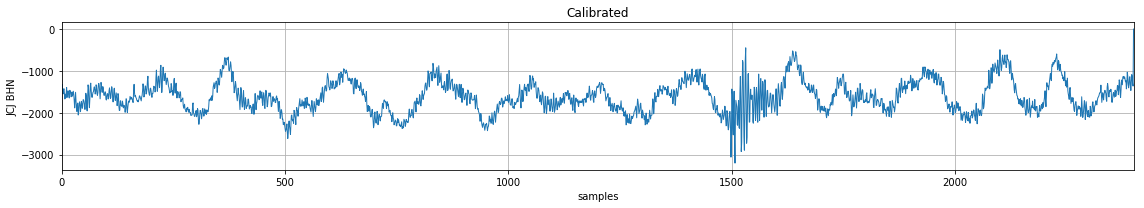

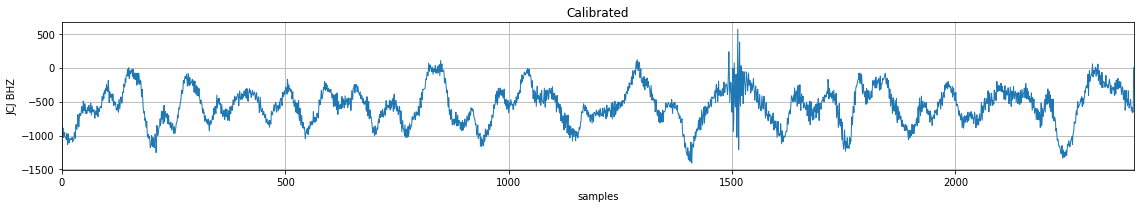

In [29]:
sta = 'JCJ'
chan = 'BHE'
data, sr = src.read_wfdisc.get_waveform_data(sta, chan, ts(2019,1,29,0,0,0), ts(2019,1,29,0,1,0), cursor_extadb2, calib=True)
src.read_wfdisc.vizualize(data, show=True, xlabel='samples', ylabel=sta+' '+chan, title='Calibrated')
sta = 'JCJ'
chan = 'BHN'
data, sr = src.read_wfdisc.get_waveform_data(sta, chan, ts(2019,1,29,0,0,0), ts(2019,1,29,0,1,0), cursor_extadb2, calib=True)
src.read_wfdisc.vizualize(data, show=True, xlabel='samples', ylabel=sta+' '+chan, title='Calibrated')
sta = 'JCJ'
chan = 'BHZ'
data, sr = src.read_wfdisc.get_waveform_data(sta, chan, ts(2019,1,29,0,0,0), ts(2019,1,29,0,1,0), cursor_extadb2, calib=True)
src.read_wfdisc.vizualize(data, show=True, xlabel='samples', ylabel=sta+' '+chan, title='Calibrated')

In [28]:
timeleb = 1563194400
starttime = timeleb - 10
endtime =   timeleb + 10

vector = []
for ch in get_channels_of_sta(sta):   
    data, sr = src.read_wfdisc.get_waveform_data(sta, ch, starttime, endtime, cursor_extadb2, calib=True)
    vector.append(numpy.array(data, dtype=numpy.float32))
data3c = numpy.hstack(vector)

In [ ]:
[row[0] for row in cursor_extadb.description]

In [30]:
import asyncio

In [ ]:
1+1

## Automatic arrivals

In [32]:
import time

station = 'ROSC'

DELTA_DIFFERENCE = 10  # time delta difference from let time arrival

query = """
SELECT  er.arid as arid,
        er.time as timea,
        ae.time as timeleb,
        er.iphase as iphase,
        ea.phase as phase,
        ea.sta as sta,
        'A' as source
        FROM idcx.arrival er, leb.assoc ea, leb.arrival ae
        WHERE er.sta='%s'
                AND ea.arid=er.arid
                AND ae.arid=ea.arid
""" % (station,)

cursor_extadb.execute(query)

print(time.time(), 'extraction of data done, preparing for inserting...')

_to_insert = []

for q in cursor_extadb:
    arid = q[0]
    timea = q[1]
    timeleb = q[2]
    iphase = q[3]
    try:
        iphasecl = get_phase_cl(iphase, DIPHASECL)
    except:
        print('Error in iphase key:', iphase)
        print('Continuing...')
        continue

    try:
        iphaseclnum = DIPHASECLNUM[iphasecl]
    except:
        print('iphaseclnum error:', iphasecl, iphase)
        continue

    phase = q[4]
    try:
        phasecl = get_phase_cl(phase, DPHASECL)
        phaseclnum = DPHASECLNUM[phasecl]
    except:
        print('problem with phase:', phase, phasecl, phaseclnum, 'skipping...')
        continue

    source = q[6]
    sta = q[5]
    channels = ','.join(get_channels_of_sta(sta))
    try:
        samprate = get_samprate_3C(sta, timeleb)
    except:
        print('no wfdisc found for time', timeleb, 'skipping...')
        continue

    starttime = timeleb - DELTA_DIFFERENCE
    endtime =   timeleb + DELTA_DIFFERENCE
    nsamp = 2*DELTA_DIFFERENCE*samprate
    calibs = numpy.array(get_calibs(sta, timeleb), dtype=numpy.float32).tobytes()

    vector = []
    for ch in get_channels_of_sta(sta):   
        data, sr = src.read_wfdisc.get_waveform_data(sta, ch, starttime, endtime, cursor_extadb2, calib=True)
        vector.append(numpy.array(data, dtype=numpy.float32))
    samples = numpy.hstack(vector).tobytes()  # must be reshaped to (3, nsamp) before use

    _to_insert.append((arid, 
                       timea, 
                       timeleb, 
                       iphase, 
                       iphasecl,
                       iphaseclnum,
                       phase,
                       phasecl,
                       phaseclnum,
                       source,
                       sta,
                       channels,
                       samprate,
                       starttime,
                       endtime,
                       nsamp,
                       calibs,
                       samples))

    
print(time.time(), 'insert query execution...')
query = """
    insert into ML_WAVEFORMS (arid, 
                               timea, 
                               timeleb, 
                               iphase, 
                               iphasecl,
                               iphaseclnum,
                               phase,
                               phasecl,
                               phaseclnum,
                               source,
                               sta,
                               channels,
                               samprate,
                               starttime,
                               endtime,
                               nsamp,
                               calibs,
                               samples)
    values (:1, :2, :3, :4, :5, :6, :7, :8, :9, :10, :11, :12, :13, :14, :15, :16, :17, :18)
    """

cursor_qandef.executemany(query, _to_insert)

print(time.time(), 'insert done, commiting...')
cursor_qandef.execute("commit")
time.time(), 

1570015831.1525507 extraction of data done, preparing for inserting...
no wfdisc found for time 1134176336.7127 skipping...


/dvlscratch/SHI/users/hofman/ML/venv3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dvlscratch/SHI/users/hofman/ML/venv3.6/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Exception:
cannot convert float NaN to integer
Exception:
cannot convert float NaN to integer
1570023010.7071402 insert query execution...
1570023020.5690556 insert done, commiting...


(1570023020.5719626,)

In [23]:
chan

'BHZ'

## Manual arrivals

## Automtic arrivals

In [49]:
import time

station = 'ROSC'

DELTA_DIFFERENCE = 10  # time delta difference from let time arrival

query = """
SELECT  ae.arid as arid,
        ae.time as timea,
        ae.time as timeleb,
        ae.iphase as iphase,
        ea.phase as phase,
        ea.sta as sta,
        'M' as source
        FROM leb.assoc ea, leb.arrival ae
        WHERE ea.sta='%s'
                AND ae.arid=ea.arid
                AND ea.arid not in (select arid from idcx.arrival where sta='%s')
""" % (station, station)

cursor_extadb.execute(query)

print(time.time(), 'extraction of data done, preparing for inserting...')

_to_insert = []

for q in cursor_extadb:
    arid = q[0]
    timea = q[1]
    timeleb = q[2]
    iphase = q[3]
    try:
        iphasecl = get_phase_cl(iphase, DIPHASECL)
    except:
        print('Error in iphase key:', iphase)
        print('Continuing...')
        continue

    try:
        iphaseclnum = DIPHASECLNUM[iphasecl]
    except:
        print('iphaseclnum error:', iphasecl, iphase)
        continue

    phase = q[4]
    try:
        phasecl = get_phase_cl(phase, DPHASECL)
        phaseclnum = DPHASECLNUM[phasecl]
    except:
        print('problem with phase:', phase, phasecl, phaseclnum, 'skipping...')
        continue

    source = q[6]
    sta = q[5]
    channels = ','.join(get_channels_of_sta(sta))
    try:
        samprate = get_samprate_3C(sta, timeleb)
    except:
        print('no wfdisc found for time', timeleb, 'skipping...')
        continue

    starttime = timeleb - DELTA_DIFFERENCE
    endtime =   timeleb + DELTA_DIFFERENCE
    nsamp = 2*DELTA_DIFFERENCE*samprate
    calibs = numpy.array(get_calibs(sta, timeleb), dtype=numpy.float32).tobytes()

    vector = []
    for ch in get_channels_of_sta(sta):   
        data, sr = src.read_wfdisc.get_waveform_data(sta, ch, starttime, endtime, cursor_extadb2, calib=True)
        vector.append(numpy.array(data, dtype=numpy.float32))
    samples = numpy.hstack(vector).tobytes()  # must be reshaped to (3, nsamp) before use

    _to_insert.append((arid, 
                       timea, 
                       timeleb, 
                       iphase, 
                       iphasecl,
                       iphaseclnum,
                       phase,
                       phasecl,
                       phaseclnum,
                       source,
                       sta,
                       channels,
                       samprate,
                       starttime,
                       endtime,
                       nsamp,
                       calibs,
                       samples))    

    
print(time.time(), 'insert query execution...')
query = """
    insert into ML_WAVEFORMS (arid, 
                               timea, 
                               timeleb, 
                               iphase, 
                               iphasecl,
                               iphaseclnum,
                               phase,
                               phasecl,
                               phaseclnum,
                               source,
                               sta,
                               channels,
                               samprate,
                               starttime,
                               endtime,
                               nsamp,
                               calibs,
                               samples)
    values (:1, :2, :3, :4, :5, :6, :7, :8, :9, :10, :11, :12, :13, :14, :15, :16, :17, :18)
    """

cursor_qandef.executemany(query, _to_insert)

print(time.time(), 'insert done, commiting...')
cursor_qandef.execute("commit")
print(time.time(), 'commit done')

1570025238.3339417 extraction of data done, preparing for inserting...
problem with phase: SSS None 3 skipping...
no wfdisc found for time 1134112994.81707 skipping...
no wfdisc found for time 1134089884.19877 skipping...
no wfdisc found for time 1134097356.69633 skipping...
no wfdisc found for time 1134089853.97355 skipping...
no wfdisc found for time 1134195232.32917 skipping...
iphaseclnum error: None PS
iphaseclnum error: None SSS
iphaseclnum error: None PPP


/dvlscratch/SHI/users/hofman/ML/venv3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dvlscratch/SHI/users/hofman/ML/venv3.6/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Exception:
cannot convert float NaN to integer
Exception:
cannot convert float NaN to integer
Exception:
cannot convert float NaN to integer
Exception:
cannot convert float NaN to integer
1570032428.9924219 insert query execution...
1570032438.0647311 insert done, commiting...
1570032438.0936239 commit done


## Manual arrivals

In [ ]:
import time
station = 'ROSC'

DELTA_DIFFERENCE = 10  # time delta difference from let time arrival

query = """
SELECT  ae.arid as arid,
        ae.time as timea,
        ae.time as timeleb,
        ae.iphase as iphase,
        ea.phase as phase,
        ea.sta as sta,
        'M' as source
        FROM leb.assoc ea, leb.arrival ae
        WHERE ea.sta='%s'
                AND ae.arid=ea.arid
                AND ae.arid not in (select arid from idcx.arrival where sta='%s')
""" % (station, station)

###qres = cursor_extadb.execute(query)

print('extracting waveforms', time.time())

for q in qres:
    try:
        arid = q[0]
        timea = q[1]
        timeleb = q[2]
        iphase = q[3]
        iphasecl = get_phase_cl(iphase, DIPHASECL)
        iphaseclnum = DIPHASECLNUM[iphasecl]
        phase = q[4]
        phasecl = get_phase_cl(phase, DPHASECL)
        phaseclnum = DIPHASECLNUM[phasecl]
        source = q[6]
        sta = q[5]
        channels = ','.join(get_channels_of_sta(sta))
        samprate = get_samprate_3C(sta, timeleb)
        starttime = timeleb - DELTA_DIFFERENCE
        endtime =   timeleb + DELTA_DIFFERENCE
        nsamp = 2*DELTA_DIFFERENCE*samprate
        calibs = numpy.array(get_calibs(sta, timeleb), dtype=numpy.float32).tobytes()
        samples = 

        query = """
        insert into ML_WAVEFORMS (arid, 
                                   timea, 
                                   timeleb, 
                                   iphase, 
                                   iphasecl,
                                   iphaseclnum,
                                   phase,
                                   phasecl,
                                   phaseclnum,
                                   source,
                                   sta,
                                   channels,
                                   samprate,
                                   starttime,
                                   endtime,
                                   nsamp,
                                   calibs,
                                   samples) 
        values (:1, :2, :3, :4, :5, :6, :7, :8, :9, :10, :11, :12, :13, :14, :15, :16, :17, :18)"
        """

        cursor_qandef.execute(query, (arid, 
                                      timea, 
                                      timeleb, 
                                      iphase, 
                                      iphasecl,
                                      iphaseclnum,
                                      phase,
                                      phasecl,
                                      phaseclnum,
                                      source,
                                      sta,
                                      channels,
                                      samprate,
                                      starttime,
                                      endtime,
                                      nsamp,
                                      calibs,
                                      samples))        
    except:
        print('insert failed')

cursor_qandef.execute("commit")

In [13]:
1+1

2

In [ ]:
#temporal condition
AND er.lddate >= to_date('''||to_char(start_date,'yy-mm-dd')||''', ''yy-mm-dd'') 
AND er.lddate  < to_date('''||to_char(end_date,'yy-mm-dd')||''', ''yy-mm-dd'') 
AND ea.lddate >= to_date('''||to_char(start_date,'yy-mm-dd')||''', ''yy-mm-dd'') 
AND ea.lddate  < to_date('''||to_char(end_date,'yy-mm-dd')||''', ''yy-mm-dd'') 

## Extract noise phases far from any arrivals

In [ ]:
get_phase_cl('S', DPHASECL)

In [ ]:
DPHASECLNUM[get_phase_cl('S', DPHASECL)]

In [ ]:
cursor_qandef.execute("insert into ML_WAVEFORMS (arid, timea, timeleb, iphase, iphasecl,iphaseclnum,phase,phasecl,phaseclnum,source,net,sta,chan,samprate,starttime,endtime,nsamp,calib,samples) values (:1, :2, :3, :4, :5, :6, :7, :8, :9, :10, :11, :12, :13, :14, :15, :16, :17, :18, :19)", 
                   (1, 1,1,'A','c',79,'sdas','cs',31,'M','urz','urz','bhz',40,232,454654,400,12,xb))      
cursor_qandef.execute("commit")

In [ ]:
cursor_qandef.execute("select * from ML_WAVEFORMS")

In [ ]:
my_str = "hello world"
my_str_as_bytes = str.encode(my_str)

In [ ]:
import numpy
x = numpy.array([[0, 1.], [2, 3]], dtype=numpy.float32)
xb = x.tobytes()

numpy.array(get_calibs('JCJ', 1563494400), dtype=numpy.float32).tobytes()

In [ ]:
type(x)

In [ ]:
a = cursor_udb.execute("select * from ML_WAVEFORMS where waveformid = 1001")
for res in a:
    print(numpy.frombuffer(res[-1].read(), dtype=numpy.int64).reshape((2,2)))

In [ ]:
a

In [ ]:
for res in a:
    print(numpy.frombuffer(res[-1].read())) #, dtype=numpy.float64))

In [ ]:
[row[0] for row in cursor_qandef.description]

In [ ]:
query = """
SELECT  er.arid as arid,
        er.time as timea,
        ae.time as timeleb,
        er.iphase as iphase,
        ea.phase as phase,
        ea.sta as sta,
        'A' as source
        FROM idcx.arrival er, leb.assoc ea, leb.arrival ae
        WHERE er.sta='%s'
                AND ea.arid=er.arid
                AND ae.arid=ea.arid
""" % (station,)

cursor_extadb.execute(query)

In [ ]:
for a in cursor_extadb:
    print(a[0])

## Test of reading data from database

In [76]:
query = """
select * from ml_waveforms where rownum <= 10
"""

cursor_qandef.execute(query)

<cx_Oracle.Cursor on <cx_Oracle.Connection to hofman[retraining]@dba1091.qandef>>

In [77]:
waves = []
for a in cursor_qandef:
    waves.append(a[-1])

In [78]:
waves

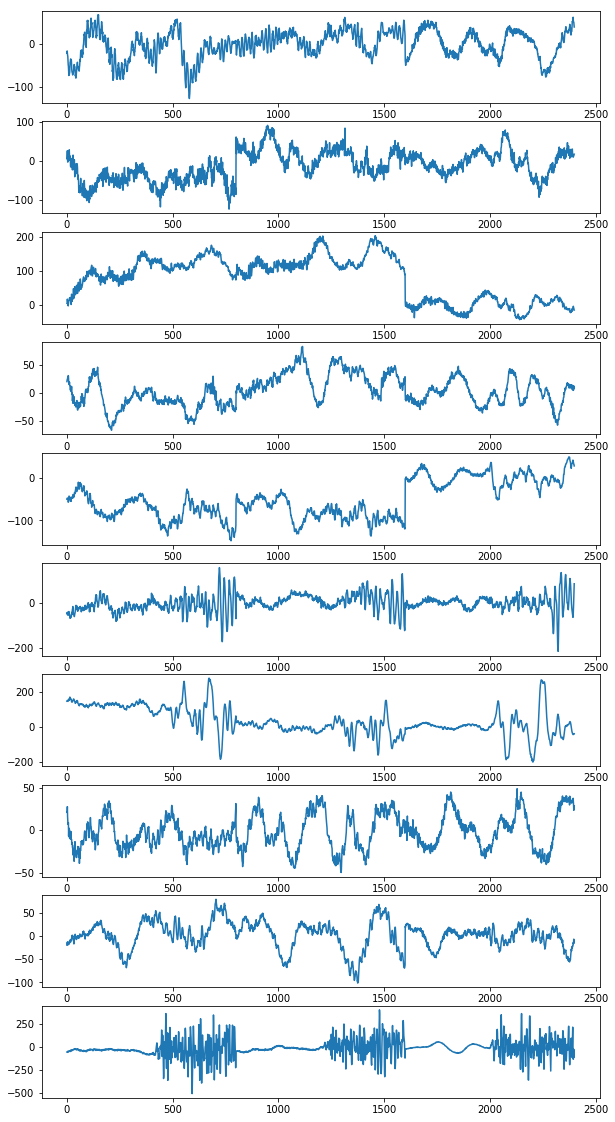

In [79]:
wav = [numpy.frombuffer(x.read(), dtype=numpy.float32) for x in waves]

fig = plt.figure(figsize=(10,20))
for i, w in enumerate(wav):
    ax = fig.add_subplot(len(wav), 1, i+1)
    ax.plot(w[:])


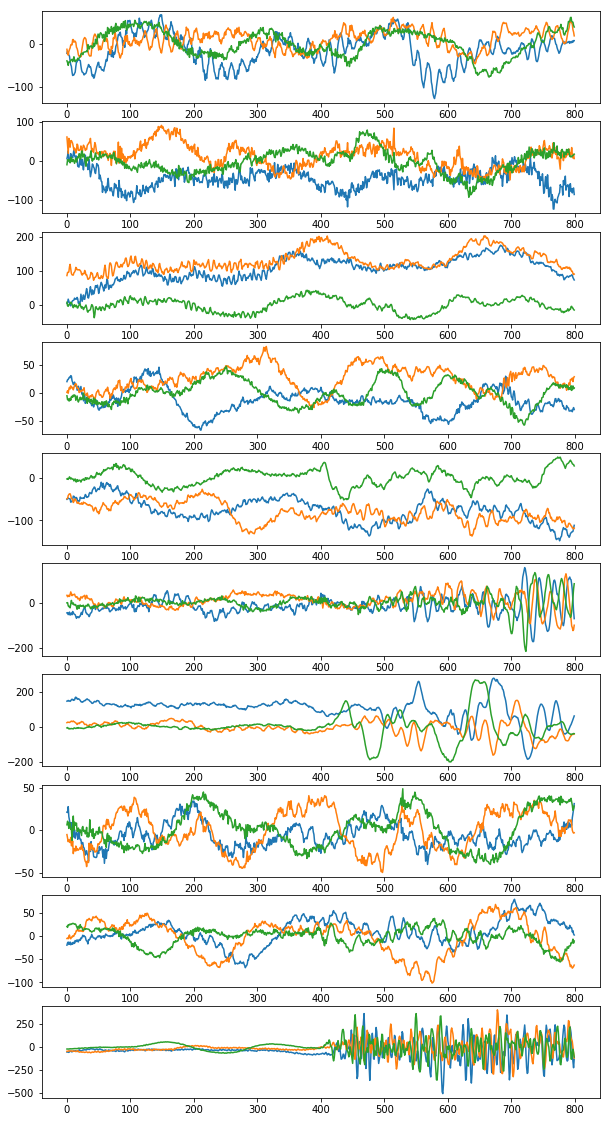

In [80]:
wav = [numpy.frombuffer(x.read(), dtype=numpy.float32).reshape((3,800)) for x in waves]

fig = plt.figure(figsize=(10,20))
for i, w in enumerate(wav):
    ax = fig.add_subplot(len(wav), 1, i+1)
    for j in range(w.shape[0]):
        ax.plot(w[j,:])
    

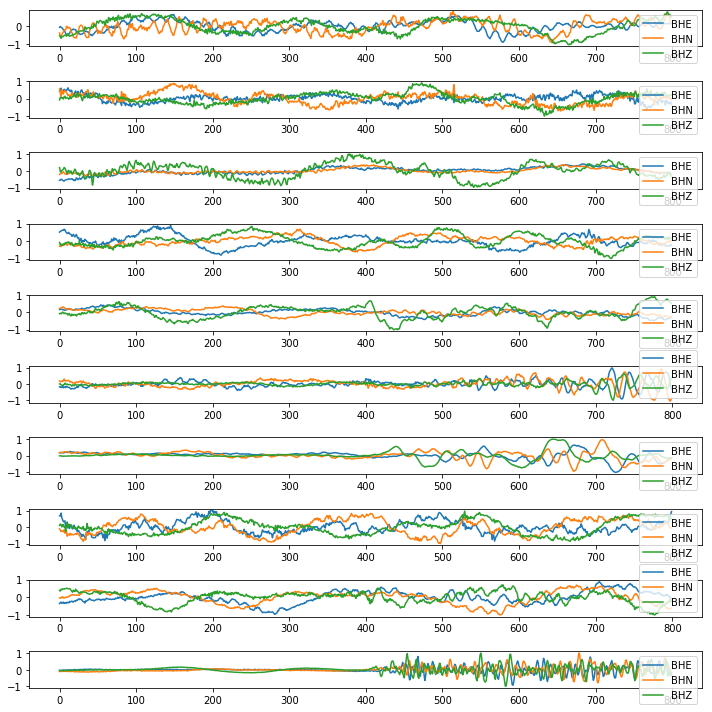

In [81]:
wav = [numpy.frombuffer(x.read(), dtype=numpy.float32).reshape((3,800)) for x in waves]

labels = ('BHE','BHN','BHZ')

fig = plt.figure(figsize=(10,10))
for i, w in enumerate(wav):
    ax = fig.add_subplot(len(wav), 1, i+1)
    for j in range(w.shape[0]):
        demean = w[j,:]-w[j,:].mean()
        maximum = numpy.max(numpy.abs(w[j,:]))
        ax.plot(demean/maximum, label=labels[j])
        
    plt.legend()
plt.tight_layout()

In [82]:
from scipy import signal
import numpy

def butter_bandpass(lowcut, highcut, fs, order=3):
     nyq = 0.5 * fs
     low = lowcut / nyq
     high = highcut / nyq
     b, a = signal.butter(order, [low, high], btype='band')
     return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    if data is None:
        return None

    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    n = data.shape[0]
    window = signal.tukey(n*3)
    #mirror extension of data by iteself on both ends
    data_ext = numpy.hstack([data[::-1], data, data[::-1]])
    y = signal.lfilter(b, a, data_ext*window)
    return y[n:2*n]

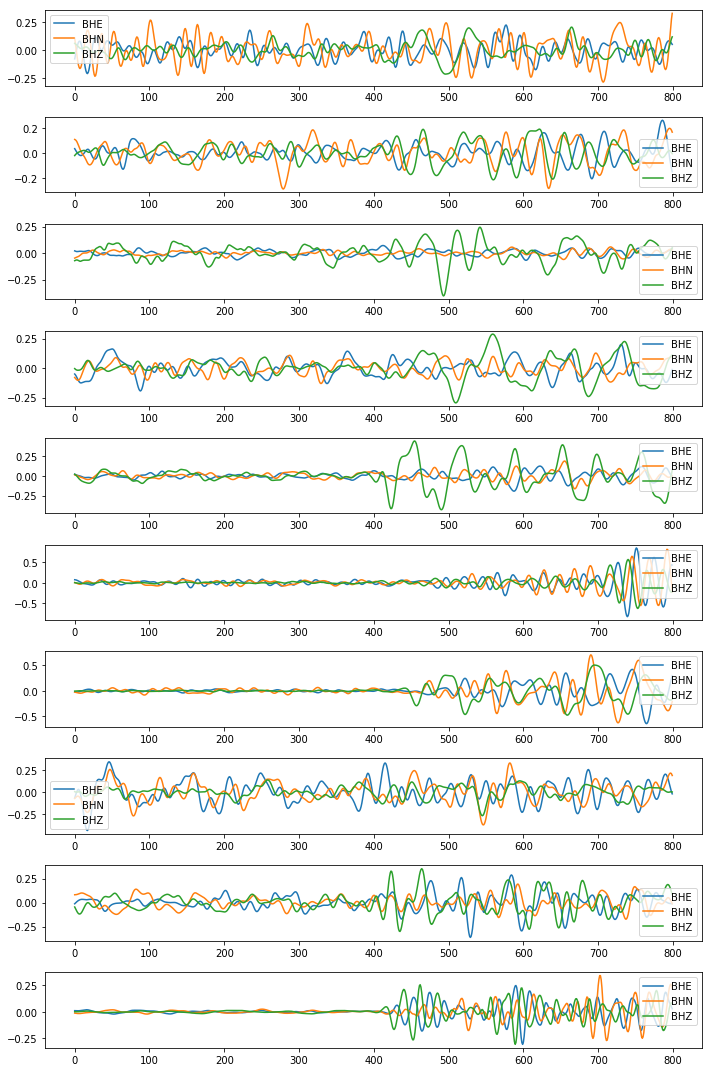

In [89]:
wav = [numpy.frombuffer(x.read(), dtype=numpy.float32).reshape((3,800)) for x in waves]

labels = ('BHE','BHN','BHZ')

fig = plt.figure(figsize=(10,15))
for i, w in enumerate(wav):
    ax = fig.add_subplot(len(wav), 1, i+1)
    for j in range(w.shape[0]):
        demean = w[j,:]-w[j,:].mean()
        maximum = numpy.max(numpy.abs(w[j,:]))
        lowcut = 0.5
        highcut = 2
        ax.plot(butter_bandpass_filter(demean/maximum, lowcut, highcut, 40, order=3), label=labels[j])
        
    plt.legend()
plt.tight_layout()

